# Negative selection algorithm for network attack detection
* Goal: Detect network attacks

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scipy.spatial.distance import euclidean
from scipy.spatial import ConvexHull

In [32]:
# Load dataset
file_path = "/Users/ap/Documents/MLroadtowisdom/ACIT4610/NSA dataset/UNSW_NB15_testing-set.csv"  # Update if needed
data = pd.read_csv(file_path)

# Drop unnecessary columns
data = data.drop(columns=['id', 'attack_cat'])

# Apply Label Encoding to categorical variables
for col in ['proto', 'service', 'state']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data.drop(columns=['label']))
y = data['label'].astype(int)

# Apply PCA (2D) for visualization
pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X_scaled)

In [33]:
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

# Keep only normal traffic for training (self)
X_train = X_train_all[y_train_all == 0]
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (25900, 2)
X_test shape: (24700, 2)


In [34]:
num_detectors = 100   # Try increasing this (e.g., 500)
generation_threshold = 0.01  # Try increasing (e.g., 0.5 or 1.0)
#generation_threshold = np.mean(np.std(X_train, axis=0)) * 1.2  # 1.2x standard deviation
print(f"Using {num_detectors} detectors")

# Detector boundaries
lower_bounds = X_train.min(axis=0)
upper_bounds = X_train.max(axis=0)

def generate_detectors(self_samples, num_detectors, threshold, lower, upper):
    """Generate detectors that do NOT match any self sample."""
    detectors = []
    attempts = 0
    evolution = []
    max_attempts = num_detectors * 100  # Safety limit
    while len(detectors) < num_detectors and attempts < max_attempts:
        candidate = np.random.uniform(lower, upper)
        if not any(euclidean(candidate, sample) < threshold for sample in self_samples):
            detectors.append(candidate)
        attempts += 1
        evolution.append(len(detectors))
    return np.array(detectors), evolution

def classify_sample(sample, detectors, threshold):
    """Classify a sample as anomaly (1) if within threshold of any detector."""
    return int(any(euclidean(detector, sample) < threshold for detector in detectors))

# Generate detectors
detectors, evolution = generate_detectors(X_train, num_detectors, generation_threshold, lower_bounds, upper_bounds)


Using 100 detectors


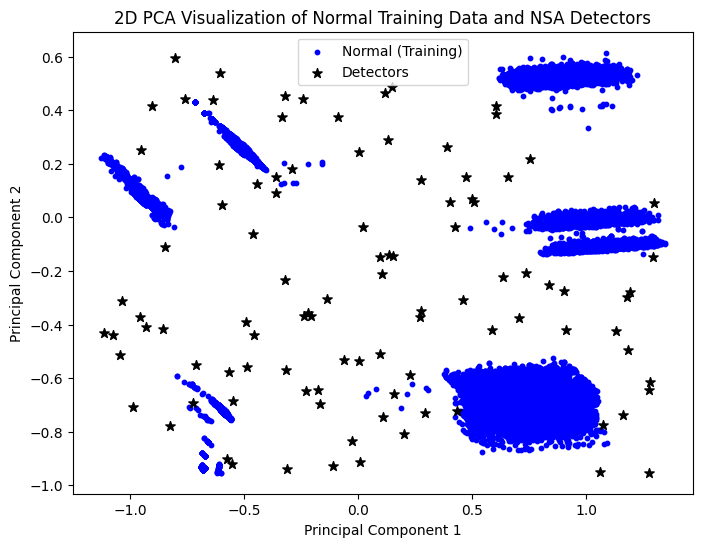

In [35]:

# Plot Normal Training Data + Detectors (Without Test Data)
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', s=10, label='Normal (Training)')
plt.scatter(detectors[:, 0], detectors[:, 1], c='black', marker='*', s=50, label='Detectors')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Visualization of Normal Training Data and NSA Detectors")
plt.legend()
plt.show()



=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.45      1.00      0.62     11100
      Attack       1.00      0.00      0.00     13600

    accuracy                           0.45     24700
   macro avg       0.72      0.50      0.31     24700
weighted avg       0.75      0.45      0.28     24700

False Positive Rate: 0.0


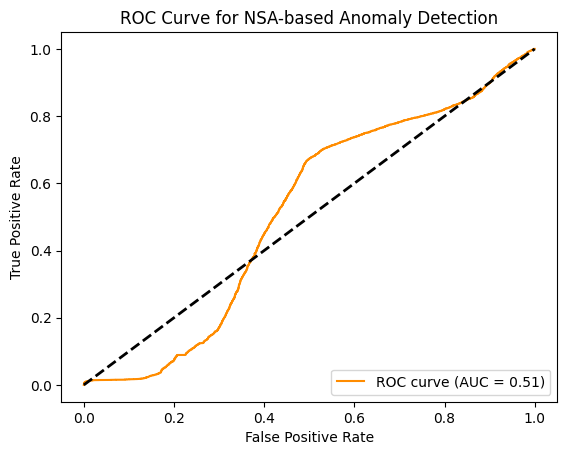

In [36]:
if len(detectors) == 0:
    raise ValueError("No detectors were generated. Adjust the threshold or placement strategy.")

predictions = np.array([classify_sample(sample, detectors, generation_threshold) for sample in X_test])

print("\n=== Classification Report ===")
print(classification_report(y_test, predictions, target_names=["Normal", "Attack"]))

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
fpr_value = fp / (fp + tn)
print("False Positive Rate:", fpr_value)

# Compute ROC Curve
scores = np.array([-min([euclidean(detector, sample) for detector in detectors]) for sample in X_test])
fpr_vals, tpr_vals, thresholds_roc = roc_curve(y_test, scores, pos_label=1)
roc_auc = auc(fpr_vals, tpr_vals)

plt.figure()
plt.plot(fpr_vals, tpr_vals, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NSA-based Anomaly Detection')
plt.legend(loc="lower right")
plt.show()

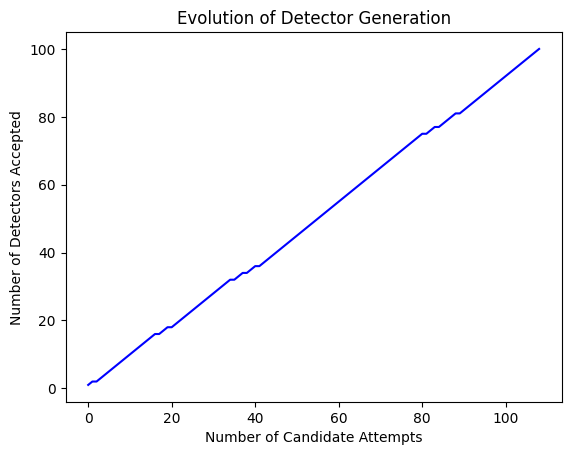

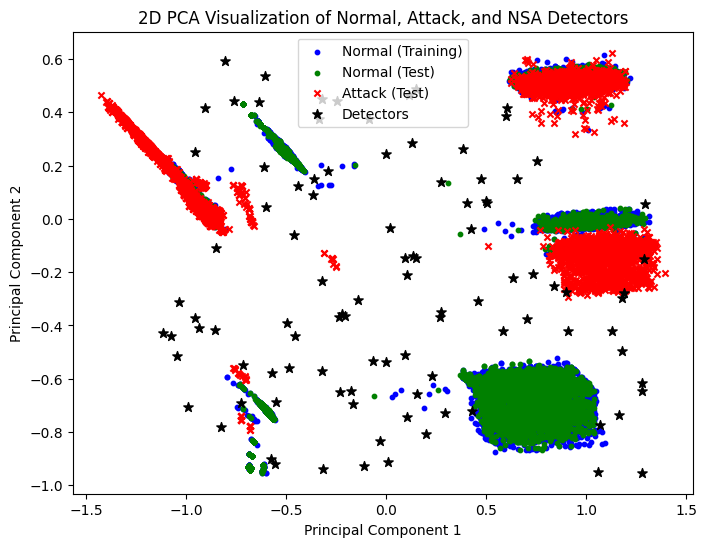

In [37]:
# -------------------------------
# 5. Evolution of Detector Generation
# -------------------------------
plt.figure()
plt.plot(evolution, color='blue')
plt.xlabel("Number of Candidate Attempts")
plt.ylabel("Number of Detectors Accepted")
plt.title("Evolution of Detector Generation")
plt.show()

# -------------------------------
# 6. 2D PCA Visualization
# -------------------------------
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c='blue', s=10, label='Normal (Training)')
normal_idx = (y_test == 0)
attack_idx = (y_test == 1)
plt.scatter(X_test[normal_idx, 0], X_test[normal_idx, 1], c='green', s=10, label='Normal (Test)')
plt.scatter(X_test[attack_idx, 0], X_test[attack_idx, 1], c='red', marker='x', s=20, label='Attack (Test)')
plt.scatter(detectors[:, 0], detectors[:, 1], c='black', marker='*', s=50, label='Detectors')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Visualization of Normal, Attack, and NSA Detectors")
plt.legend()
plt.show()
